In [1]:
import CS_Indicators as CS
import OpenCity
from brix import Indicator, Handler

### TODO
- make a base class for proximity and density indicators to elimate repetition
- state only used for state.geom and subsetting thereof- really just need a shape file
- relevant column names should be in a settings file
- all US-specific functionality should be in OpenCity
- separate out functions for combining grid stats with zone stats- repeated in both indicators now
- only consider interactive cells in updates

In [2]:
table_name='providence_test'
geom_type='block_group'

### Create the State and prepare data

Initialise GEOGRID: <Response [200]>
Getting geometry (block_group) for state: Rhode Island


/Volumes/GoogleDrive/My Drive/OpenCity/OpenCity.py:74: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids=self.geom['geometry'].centroid


Getting WAC data from https://lehd.ces.census.gov/data/lodes/LODES7/
	 Formatting WAC data
Getting RAC data from https://lehd.ces.census.gov/data/lodes/LODES7/
	 Formatting RAC data


<AxesSubplot:>

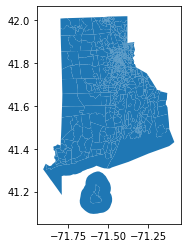

In [3]:
properties=CS.init_geogrid(table_name)
state_fips=CS.identify_state(properties)

st=OpenCity.US_State(state_fips, year=2018, geom_type=geom_type)
st.get_geometry()
# st.remove_non_urban_zones()
st.get_lodes_data( include=['wac', 'rac'])
st.add_lodes_cols_to_shape()
st.geom.plot()

In [4]:
H=Handler(table_name=table_name)
H.reset_geogrid_data()

In [5]:
st.get_lodes_data(include=['od'])

Getting OD data from https://lehd.ces.census.gov/data/lodes/LODES7/
	 Formatting OD data


In [25]:
import urllib
import geopandas as gpd
import osmnx
import PreCompOsmNet
import numpy as np
import requests
import json
import random

def mode_choice_model(all_trips_df):
    all_trips_df['mode']=random.choices(['walk', 'drive'], k=len(all_trips_df))
    return all_trips_df

class Mobility_indicator(Indicator):
    def setup(self, state, table_name, model_radius, external_hw_tags=["motorway","motorway_link","trunk","trunk_link"]):
        self.external_hw_tags=external_hw_tags
        self.state=state
        self.table_name=table_name
        if not hasattr(self.state, 'od'):
            self.state.get_lodes_data(include=['od'])
        self.get_geogrid()
        self.get_overlap_geoids()
        self.state.geom['sim_area']=self.state.geom.index.isin(self.overlapping_geoids)
        self.state.subset_geom_by_distance([self.geogrid['x_centroid'].mean(), self.geogrid['y_centroid'].mean()],
                                           model_radius, 'model_area')
        simpop_df=state.lodes_to_pop_table(
            model_subset_name='model_area', sim_subset_name='sim_area')
        self.base_simpop_df=simpop_df.copy()
        self.build_mobsys() 
        print('Init simulation')
        model_zones=self.state.return_geometry('model_area')
        sim_zones=self.state.return_geometry('sim_area')
        self.sim=OpenCity.Simulation(simpop_df, self.mob_sys, model_zones, sim_geoids=sim_zones.index)
        self.sim.set_choice_models(mode_chooser=mode_choice_model)

        
    def get_geogrid(self):
        # repetition with proximity indicator
        get_url='https://cityio.media.mit.edu/api/table/'+self.table_name
        with urllib.request.urlopen(get_url+'/GEOGRID') as url:
            self.geogrid=gpd.read_file(url.read().decode())
        centroids=self.geogrid['geometry'].centroid
        self.geogrid['x_centroid']=[c.x for c in centroids]
        self.geogrid['y_centroid']=[c.y for c in centroids]
                       
    def get_overlap_geoids(self):
        # repetition with proximity indicator
        """
        find the geoids of the baseline zones which overlap with hthe geogrid
        
        """
        self.state.geom['copy_GEOID']=self.state.geom.index
        grid_intersect_zones=gpd.overlay(self.geogrid, self.state.geom, 'intersection')
        self.overlapping_geoids=grid_intersect_zones['copy_GEOID'].unique()
        
    def build_mobsys(self):
        print('Building Mobility System')
        print('\t getting graph')
        G_drive_sim = self.get_graph_buffered_to_hw_type(self.state.geom.loc[self.state.geom['sim_area']], 
                                                       self.external_hw_tags, 'drive')
        G_drive_model=osmnx.graph_from_polygon(self.state.geom.loc[self.state.geom['model_area']].unary_union,
                                 network_type='drive', custom_filter='["highway"~"{}"]'.format('|'.join(self.external_hw_tags)))
        G_drive_combined=osmnx.graph.nx.compose(G_drive_model,G_drive_sim)
#         for edge in list(G_walk.edges):
#             G_walk.edges[edge]['speed_kph']=4.8
        G_drive_combined=osmnx.add_edge_speeds(G_drive_combined)
        G_drive_combined=PreCompOsmNet.simplify_network(G_drive_combined)
        G_drive_combined=osmnx.add_edge_travel_times(G_drive_combined)
        
        for edge in list(G_drive_combined.edges):
            G_drive_combined.edges[edge]['travel_time_walk']=G_drive_combined.edges[edge]['length']/(4800/3600)

        G_drive_combined=osmnx.utils_graph.get_undirected(G_drive_combined)
        fw_pred_drive=PreCompOsmNet.pre_compute_paths(G_drive_combined)
        pre_comp_drive=PreCompOsmNet.PreCompOSMNet(G_drive_combined, fw_pred_drive)
        networks={'drive': pre_comp_drive, 'walk': pre_comp_drive}
        
        drive_dict={
            'target_network_id': 'drive',
            'travel_time_metric': 'travel_time'}
        walk_dict={
            'target_network_id': 'walk',
            'travel_time_metric': 'travel_time_walk'}
        
        modes={'drive': OpenCity.Mode(drive_dict), 'walk': OpenCity.Mode(walk_dict)}

        self.mob_sys=OpenCity.MobilitySystem(modes=modes,
                              networks=networks)
        
    def get_graph_buffered_to_hw_type(self,geom, external_hw_tags, network_type):
        for buffer in [i*200 for i in range(10)]:
            print('Buffer : {}'.format(buffer))
            geom_projected=osmnx.projection.project_gdf(geom)
            geom_projected_buffered=geom_projected.unary_union.buffer(buffer)

            geom_projected_buffered_gdf=gpd.GeoDataFrame(geometry=[geom_projected_buffered], crs=geom_projected.crs)
            geom_wgs_buffered_gdf=geom_projected_buffered_gdf.to_crs(geom.crs) 

            G_temp=osmnx.graph.graph_from_polygon(geom_wgs_buffered_gdf.iloc[0]['geometry'], network_type=network_type)
            all_hw_tags=[e[2]['highway'] for e in G_temp.edges(data=True)]

            if any([tag in all_hw_tags for tag in external_hw_tags]):
                return G_temp
            print('Doesnt contain external link types')
        print('Warning: internal network will not connect to external network')
        return G_temp 
        
        
    def routes_to_deckgl_trip(self, route_table):
#         attr_map={'earnings': 
#               {0: {'name': 'Low Income', 'color': '#1b9e77'},
#                1: {'name': 'Med Income', 'color': '#d95f02'},
#                2: {'name': 'High Income', 'color': '#7570b3'}}}
        mode_id_map={'drive': "0", "cycle": "1", "walk": "2", "pt": "3"}
        profile_id_map={'u1250':"0", '1250to3333':"1",  '3333plus':"2"}
        attr_map={"mode": {
                    "0": {
                    "color": "#e41a1d",
                    "name": "Drive"
                    },
                    "1": {
                    "color": "#377eb8",
                    "name": "Cycle"
                    },
                    "2": {
                    "color": "#4daf4a",
                    "name": "Walk"
                    },
                    "3": {
                    "color": "#ffff33",
                    "name": "Public Transport"
                    }},
                 "profile": {
                    "0": {
                    "color": "#7fc97f",
                    "name": "Low Income"
                    },
                    "1": {
                    "color": "#beaed4",
                    "name": "Med Income"
                    },
                    "2": {
                    "color": "#fdc086",
                    "name": "High Income"
                    }}}
                    #         earnings_to_ind={'u1250': 0, '1250to3333': 1, '3333plus': 2}
        trips=[]
        for ind, row in route_table.iterrows():
            coords=row['attributes']['coordinates']
            if len(coords)>1:
                cum_time=np.cumsum(row['attributes']['travel_time'])
                start_time=int(row['start_time'])
                timestamps=[int(start_time)] + [int(start_time)+ int(ct) for ct in cum_time]
                this_trip={'path': coords, 'timestamps': timestamps}
#                 for attr in ['earnings']:
#                     this_trip[attr]=row[attr]
#                 this_trip['earnings']=earnings_to_ind[row['earnings']]
                this_trip['mode']=mode_id_map[row['mode']],
                this_trip['profile']=profile_id_map[row['earnings']]
                trips.append(this_trip)
        return {'attr': attr_map, 'trips': trips}
        
    def simulate(self, simpop_df):
        print('Schedules and locations')
        simpop_df=self.sim.create_simple_activity_schedules(simpop_df)
        print('Trip table')
        all_trips_df=self.sim.create_trip_table(simpop_df)
        print('Route table')
        route_table=self.sim.get_routes_table(all_trips_df)
        print('DeckGL')
        deckgl_trips=self.routes_to_deckgl_trip(route_table)
        return deckgl_trips
    
    def post_trips(self, deckgl_trips):
        post_url='https://cityio.media.mit.edu/api/table/update/'+self.table_name
        r = requests.post(post_url+'/ABM2', data = json.dumps(deckgl_trips))
        print('Post ABM: {}'.format(r))

In [26]:
m=Mobility_indicator(st, table_name, model_radius=3000)

<ipython-input-25-20238e2f8a19>:42: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids=self.geogrid['geometry'].centroid


	 Subsetting zones by distance
Using 883 of 154176 rows in OD data
0 of 883
Building Mobility System
	 getting graph
Buffer : 0
Doesnt contain external link types
Buffer : 200
Doesnt contain external link types
Buffer : 400
	 Simplified from 2005 to 1806 edges and 803 to 676 nodes
	 Pre-computing paths
Init simulation
Getting internal nodes


/Users/doorleyr/anaconda3/envs/brix/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Finding closest nodes to every zone centroid


In [17]:
# osmnx.plot.plot_graph(m.mob_sys.networks['drive'].G)

In [27]:
N_max=1000
simpop_df=m.base_simpop_df.sample(min(N_max, len(m.base_simpop_df)))
# deck=m.simulate(simpop_df)
# len(deck['trips'])

In [28]:
simpop_df=m.sim.create_simple_activity_schedules(simpop_df)
print('Trip table')
all_trips_df=m.sim.create_trip_table(simpop_df)

route_table=m.sim.get_routes_table(all_trips_df)
print('DeckGL')
deckgl_trips=m.routes_to_deckgl_trip(route_table)

Trip table


/Volumes/GoogleDrive/My Drive/OpenCity/OpenCity.py:652: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  route_table_this_mode['node_path']=routes['node_path']
/Volumes/GoogleDrive/My Drive/OpenCity/OpenCity.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  route_table_this_mode['attributes']=routes['attributes']


DeckGL


In [29]:
# import matplotlib.pyplot as plt
# _=plt.hist(all_trips_df['start_time'], bins=[i*70 for i in range(1000)])

In [30]:
m.post_trips(deckgl_trips)

Post ABM: <Response [200]>


<AxesSubplot:>

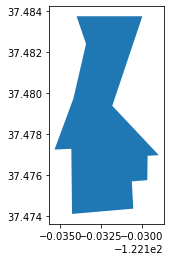

In [159]:
H=Handler(table_name=table_name)
H.reset_geogrid_data()

In [134]:
geogrid_intersect_interactive

,height,id,interactive,name,geometry
0,1,1,Web,Road,"POLYGON ((-122.13374 37.48329, -122.13381 37.4..."
1,4,2,Web,Residential,"POLYGON ((-122.13318 37.48329, -122.13374 37.4..."
2,4,3,Web,Residential Low Density,"POLYGON ((-122.13262 37.48329, -122.13318 37.4..."
3,10,4,Web,Office,"POLYGON ((-122.13205 37.48329, -122.13262 37.4..."
4,4,5,Web,Institutional,"POLYGON ((-122.13149 37.48329, -122.13205 37.4..."
...,...,...,...,...,...
134,1,175,Web,Road,"POLYGON ((-122.13149 37.47611, -122.13149 37.4..."
135,4,176,Web,Residential,"POLYGON ((-122.13093 37.47611, -122.13093 37.4..."
136,4,177,Web,Residential Low Density,"POLYGON ((-122.13093 37.47566, -122.13093 37.4..."
137,4,178,Web,Residential Low Density,"POLYGON ((-122.13036 37.47611, -122.12980 37.4..."


### Create and run the Cityscope model

In [4]:
d=CS.Density_Indicator(state=st, table_name_x=table_name)
# d.link_table(table_name=table_name)

p=CS.Proximity_Indicator(state=st, table_name=table_name)
# p.link_table(table_name=table_name)

H.add_indicator(d)
H.add_indicator(p)

# d.load(state=st, table_name_x=table_name)
# p.load(state=st, table_name=table_name) 

providence_test


/Volumes/GoogleDrive/My Drive/OpenCity/CS_Indicators.py:217: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids=self.geogrid['geometry'].centroid


	 Subsetting zones by distance
Getting central nodes
Calculating baseline scores
Dens Ind: 0:00:00.048311
Post heatmap: <Response [200]>
Prox Ind: 0:00:05.476036
Prox HM: 0:00:00.740372


In [ ]:
H.listen()

Dens Ind: 0:00:00.041167
Post heatmap: <Response [200]>
Prox Ind: 0:00:05.644642
Prox HM: 0:00:00.739074
Dens Ind: 0:00:00.040954
Post heatmap: <Response [200]>
Prox Ind: 0:00:05.399807
Prox HM: 0:00:00.741478
Dens Ind: 0:00:00.058446
Post heatmap: <Response [200]>
Prox Ind: 0:00:06.391316
Prox HM: 0:00:00.741262
Dens Ind: 0:00:00.051727
Post heatmap: <Response [200]>
Prox Ind: 0:00:07.339707
Prox HM: 0:00:00.748413
Dens Ind: 0:00:00.045716
Post heatmap: <Response [200]>
Prox Ind: 0:00:06.898705
Prox HM: 0:00:00.739359
Dens Ind: 0:00:00.068232
Post heatmap: <Response [200]>
Prox Ind: 0:00:07.605604
Prox HM: 0:00:00.740228
Dens Ind: 0:00:00.046034
Post heatmap: <Response [200]>
Prox Ind: 0:00:06.758555
Prox HM: 0:00:00.736733
Dens Ind: 0:00:00.086114
Post heatmap: <Response [200]>
Prox Ind: 0:00:11.912660
Prox HM: 0:00:00.742446


/Users/doorleyr/anaconda3/envs/brix/lib/python3.9/site-packages/brix/classes.py:871: UserWarning: Indicator not working:0001
  warn('Indicator not working:'+str(indicator_name))
/Users/doorleyr/anaconda3/envs/brix/lib/python3.9/site-packages/brix/classes.py:871: UserWarning: Indicator not working:0002
  warn('Indicator not working:'+str(indicator_name))


Dens Ind: 0:00:00.054536
Post heatmap: <Response [200]>
Prox Ind: 0:00:06.781914
Prox HM: 0:00:00.740194
Dens Ind: 0:00:00.076535
Post heatmap: <Response [200]>
Prox Ind: 0:00:08.713110
Prox HM: 0:00:00.747973


In [ ]:
# geogrid_data=H.get_geogrid_data()

# for ind in p.overlapping_geoids:
#     zones, cells = p.zone_to_reachable[ind]['zones'], p.zone_to_reachable[ind]['cells']


#     stats_to_aggregate=['total_pop_rac', 'total_employ_wac']+[
#             col for col in p.state.geom.columns if (('naics' in col) or ('income' in col))]
#     reachable_area_stats=dict(p.state.geom.loc[zones, stats_to_aggregate].sum())
#     if geogrid_data is not None:
#         # geogrid_data_reachable=[geogrid_data[c] for c in cells]
#         side_length=geogrid_data.get_geogrid_props()['header']['cellSize']
#         type_def=geogrid_data.get_type_info()
#         agg_types, agg=CS.aggregate_types_over_grid2(geogrid_data, side_length=side_length, type_def=type_def, which_cells=cells)

In [ ]:
# geogrid_data=H.get_geogrid_data()

In [ ]:
# from collections import Counter
# def aggregate_types_over_grid2(geogrid_data, side_length, type_def):
#     g=geogrid_data.as_df()
#     g['height2']=[h[-1] for h in g['height'].values]
#     agg=g.groupby('name').agg({'height2': sum})
#     agg['sqm']=agg.apply(lambda row: row['height2']*side_length*side_length, axis=1)
#     agg['type_info']=agg.apply(lambda row: type_def[row.name], axis=1)
#     agg['sqmpp']=agg.apply(lambda row: row['type_info']['sqm_pperson'] if 'sqm_pperson' in row['type_info'] else 50, axis=1)
#     agg['capacity']=agg.apply(lambda row:row['sqm']/row['sqmpp'], axis=1)
#     return agg['capacity'].to_dict(), agg

# def aggregate_attributes_over_grid2(agg, attr, digits=None):
#     agg['attr_props']=agg.apply(lambda row: row['type_info'][attr], axis=1)
#     agg['attr_capacity']=agg.apply(lambda row: {} if row['attr_props'] is None else {
#         code: row['attr_props'][code]*row['capacity'] for code in row['attr_props']}, axis=1)
#     c=Counter()
#     for ind, row in agg.iterrows():
#         c.update(row['attr_capacity'])
#     if digits is not None:
#         c_2=Counter()
#         for code in c:
#             c_2.update({code[0:digits]: c[code]})
#         return c_2
#     return dict(c)   